In [1]:
import sys
if "../src" not in sys.path:
    sys.path.append("../src")
import json
import numpy as np
from itertools import chain
from tqdm.auto import tqdm
from pathlib import Path
from praatio import textgrid
from weave import Speech, Utterance, Word, Character, Phone

In [2]:
# data_paths = Path("../data/retro_labels/").glob("*.mfa.json")
data_paths = Path("../data/retro_labels/").glob("*.mfa.json")
data_paths = list(data_paths)

In [25]:
tgt_word = "因為"
phones_found = []

In [26]:
for data_path_x in tqdm(data_paths):
  data_dict = json.loads(data_path_x.read_text())
  speech = Speech.from_dict(data_dict)
  for utt_x in speech.utterances:
    for word_x in utt_x.words:
      if word_x.label == tgt_word:
        phones_found.append(list(word_x.iter_phones()))

nphone, nphone_dist = np.unique([len(x) for x in phones_found], return_counts=True)
all_phones = set(p.label for p in chain.from_iterable(x for x in phones_found))
phone_list = sorted(phones_found, key=lambda x: len(x), reverse=True)[0]
phone_list = [x.label for x in phone_list]
phone_list = phone_list + sorted(list((all_phones-set(phone_list))))
phone_table = {x: i for i, x in enumerate(phone_list)}

  0%|          | 0/15 [00:00<?, ?it/s]

In [27]:
phone_table

{'i˥˥': 0, 'n': 1, 'w': 2, 'ej˥˩': 3}

In [28]:
pho_mat = []
for phones_x in phones_found:
  pho_vec = np.zeros(len(phone_table))
  for pho in phones_x:
    pho_idx = phone_table[pho.label]
    pho_dur = pho.end - pho.start
    pho_vec[pho_idx] = pho_dur
  pho_mat.append(pho_vec)
pho_mat = np.array(pho_mat)

Text(0.5, 0.95, '因為')

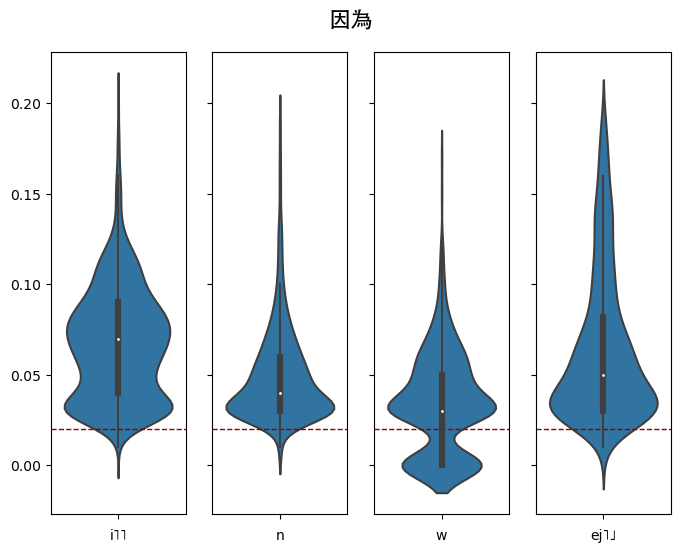

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, len(phone_list), figsize=(8, 6), sharey=True)
for i, ax in enumerate(axes):
  pho_vec = pho_mat[:, i]
  pho_vec = pho_vec[pho_vec < .2]
  ax.axhline(0.02, color="darkred", linewidth=1, linestyle="--")
  sns.violinplot(y=pho_vec, ax=ax)
  ax.set_xlabel(phone_list[i])
fig.suptitle(tgt_word, fontfamily="HeiTi TC", fontsize=16, y=.95)

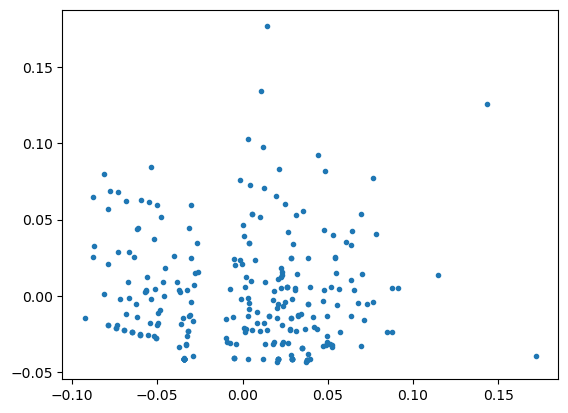

In [9]:
from sklearn.decomposition import PCA
pca = PCA()
pho_proj = pca.fit_transform(pho_mat)
plt.plot(pho_proj[:, 0], pho_proj[:, 1], '.')